In [2]:
from xgboost import XGBClassifier
import warnings
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from tabpfn_new.scripts.transformer_prediction_interface import TabPFNClassifier, MedPFNClassifier
from tabpfn_new.scripts.model_builder import load_model
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
from evaluate import *
from load_models import *
import matplotlib.pyplot as plt
import torch
import openml
import time
import matplotlib as mpl
#from autogluon.tabular import TabularDataset, TabularPredictor
pd.set_option('display.expand_frame_repr', False)

In [3]:
path = "datasets/data_all.csv"
all_data, labels = get_microbiome(path)
all_data = remove_zero_features(all_data)
all_data, labels = unison_shuffled_copies(all_data, labels, seed=42)
#all_data = top_anova(all_data, labels)

## Baseline 

In [173]:
save = False
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 5
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 10
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
#run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
#run_name2 = "large_mlp_var_balance_05weight_anova" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ft
#run_name = "large_mlp_var_balance_05weight_anova_bestwithnoisebnn_100_moreweight" ## best start, ft no so good
#run_name = "medium_mlp_var_balance_05weight_anova_200" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
#path2 = dir_path + f"/logs/trainrun_{run_name2}"
#path3 = dir_path + f"/logs/trainrun_{run_name3}"
filename = "model"



models = [
    MajorityClass(),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=1, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
                    ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    #CatBoostGrid(),
    #XGBoostGrid(),
    LogisticRegressionClassifier(), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs_forest)
]
reducer  = AnovaSelect()


results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                            index=[m.__class__.__name__ for m in models],
                            columns=metrics+["runtime"])
results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                           index=[m.__class__.__name__ for m in models],
                           columns=metrics+["runtime"])

for ii, model in enumerate(models):
    results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
        model, all_data, labels, metrics, strat_split, cv, sampling, 
        reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
        recomp=recomp)

results_mean = results_mean.add_suffix(" mean")
results_std = results_std.add_suffix(" std")
results_full = pd.concat((results_mean, results_std), axis=1)
cols = results_full.columns.tolist()
new_cols = []
for i in range(int(len(cols)/2)):
    new_cols.append(cols[i])
    new_cols.append(cols[i+int(len(cols)/2)])
results_full = results_full[new_cols]
red_name = reducer.__class__.__name__
if save:
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = f'results/{red_name}/baseline_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}.csv'
    results_full.to_csv(save_path)
print("\n", "\n", red_name, "\n", results_full.round(3))
#print(results_full.sort_values("roc_auc mean").round(3))

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 AnovaSelect 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.946         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
XGBClassifier                         0.948         0.010           0.463          0.206        0.317       0.203         0.848        0.081    0.364   0.195         0.027        0.032
MedPFNClassifier                      0.955         0.013           0.679          0.225        0.433       0.111         0.919        0.052    0.511   0.125         3.083        0.237
RandomForestClassifier                0.951         0.012           0.347          0.372        0.200       0.233         0.902        0.059    0.249   0.278         0.184        0.011
LogisticRegressionClassifier          0.939         0.014

## Baseline Repeated cross validation

In [119]:
save = False
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 10
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 10
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
#run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
#run_name2 = "large_mlp_var_balance_05weight_anova" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ft
#run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ft
#run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100_moreweight" ## best start, ft no so good
#run_name = "medium_mlp_var_balance_05weight_anova_200" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
#path2 = dir_path + f"/logs/trainrun_{run_name2}"
#path3 = dir_path + f"/logs/trainrun_{run_name3}"
filename = "model"



models = [
    #MajorityClass(),
    #XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=1, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
    #                ft_epochs=ft_epochs, ft_lr=ft_lr),
    #RandomForestClassifier(),
    #AutoGluon(),
    CatBoostGrid(),
    XGBoostGrid(),
    #LogisticRegressionClassifier(), 
    #TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs_forest)
]
reducer  = AnovaSelect()


results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                            index=[m.__class__.__name__ for m in models],
                            columns=metrics+["runtime"])
results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                           index=[m.__class__.__name__ for m in models],
                           columns=metrics+["runtime"])

size = min(labels.shape[0],np.floor(max_samples*(cv/(cv-1))))
runs = int(all_data.shape[0]//size)
data_sections, label_sections = stratified_split(all_data, labels,cv=runs)
print(np.array(data_sections).shape, size)

for section in range(runs):
    print("Step: ", section)
    for ii, model in enumerate(models):
        out_mean, out_std = cross_validate_sample(
            model, data_sections[section], label_sections[section], metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)
        results_mean.iloc[ii,:] += out_mean
        results_std.iloc[ii,:] += out_std 
    
results_mean = results_mean.add_suffix(" mean")
results_std = results_std.add_suffix(" std")
results_full = pd.concat((results_mean, results_std), axis=1)
cols = results_full.columns.tolist()
new_cols = []
for i in range(int(len(cols)/2)):
    new_cols.append(cols[i])
    new_cols.append(cols[i+int(len(cols)/2)])
results_full = results_full[new_cols]
results_full = results_full/runs
red_name = "repeated_cv"
if save:
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = f'results/{red_name}/baseline_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}.csv'
    results_full.to_csv(save_path)
print("\n", "\n", red_name, "\n", results_full.round(3))
#print(results_full.sort_values("roc_auc mean").round(3))

(10, 1145, 1391) 1137.0
Step:  0



KeyboardInterrupt




['MedPFNClassifier' 'MedPFNClassifier' 'MedPFNClassifier'
 'RandomForestClassifier' 'LogisticRegressionClassifier'
 'TabPFNClassifier' 'TabForestPFNClassifier']


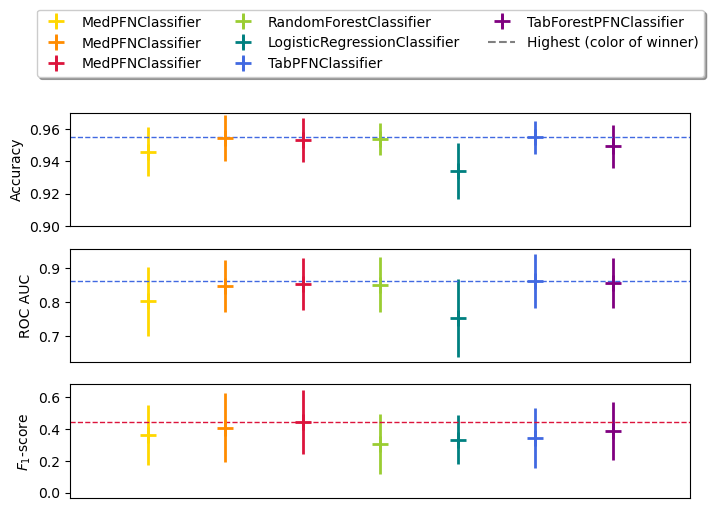

In [164]:
save_path = f'results/repeated_cv/baseline_cv10_mxsamp1024_sd42_ovrw1.csv'
data = pd.read_csv(save_path)
fig, axs = plt.subplots(3, 1, figsize=(8, 5), dpi=100, sharex=True)
print()
# Plot error bar plots in each subplot
models = data.iloc[:,0].values
colors = ["gold", "darkorange", "crimson", "yellowgreen", "teal", "royalblue", "purple"]
print(models)
x = np.arange(len(data.iloc[:,1].values))
for i in range(7):
    axs[0].set_xticks([])
    axs[0].set_xlim(-1,7)
    axs[0].errorbar(x[i], data.iloc[i,1], yerr=data.iloc[i,2], fmt='+', mew=2, lw=2, markersize=12, capsize=0, color=colors[i], label=models[i])
    axs[0].set_ylabel("Accuracy")
    
    axs[1].errorbar(x[i], data.iloc[i,7], yerr=data.iloc[i,8], fmt='+', mew=2, lw=2, markersize=12, capsize=0, color=colors[i])
    axs[1].set_ylabel("ROC AUC")
    #axs[1].legend()
    
    axs[2].errorbar(x[i], data.iloc[i,9], yerr=data.iloc[i,10], fmt='+', mew=2, lw=2, markersize=12, capsize=0, color=colors[i])
    axs[2].set_ylabel(r"$F_1$-score")
    #axs[2].legend()
    
    #axs[3].errorbar(x[i], data.iloc[i,7], yerr=data.iloc[i,8], fmt='+', mew=2, lw=2, markersize=12, capsize=0, color=colors[i])
    #axs[3].set_ylabel("")
    #axs[3].legend()
    
    # Set common x-axis label
    #axs[3].set_xlabel("X-axis")

inds = [1,7,9]
for j in range(3):
    axs[j].hlines(np.max(data.iloc[:,inds[j]].values),-1,7, lw=1, colors=colors[np.argmax(data.iloc[:,1+2*j].values)], linestyles="dashed")
    #axs[j].grid()
axs[j].hlines(0,0,0,linestyles="dashed", colors=["gray"], label="Highest (color of winner)")
axs[0].set_ylim(0.9,0.97)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
# Adjust layout to prevent overlap
#plt.tight_layout()
plt.show()

## Mine vs static vs normal

In [9]:
save = True
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 20
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" 
run_name2 = "medium_mlp_static_balance_05weight_anova_bestwithnoisebnn_100" 
run_name3 = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100_normalprior" 
path = dir_path + f"/logs/trainrun_{run_name}"
path2 = dir_path + f"/logs/trainrun_{run_name2}"
path3 = dir_path + f"/logs/trainrun_{run_name3}"
filename = "model"


models = [
    
    #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    #MedPFNClassifier(base_path=path2, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    #MedPFNClassifier(base_path=path3, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process, ft_epochs=ft_epochs, ft_lr=ft_lr),
    MedPFNClassifier(base_path=path2, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,ft_epochs=ft_epochs, ft_lr=ft_lr),
    MedPFNClassifier(base_path=path3, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,ft_epochs=ft_epochs, ft_lr=ft_lr),
]
reducer  = AnovaSelect()
#for reducer in [AnovaSelect(), RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
#data = clr(all_data)

#all_data = normalize(all_data)

results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                            index=[m.__class__.__name__ for m in models],
                            columns=metrics+["runtime"])
results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                           index=[m.__class__.__name__ for m in models],
                           columns=metrics+["runtime"])

for ii, model in enumerate(models):
    results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
        model, all_data, labels, metrics, strat_split, cv, sampling, 
        reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
        recomp=recomp)

results_mean = results_mean.add_suffix(" mean")
results_std = results_std.add_suffix(" std")
results_full = pd.concat((results_mean, results_std), axis=1)
cols = results_full.columns.tolist()
new_cols = []
for i in range(int(len(cols)/2)):
    new_cols.append(cols[i])
    new_cols.append(cols[i+int(len(cols)/2)])
results_full = results_full[new_cols]
red_name = "nomethodscompare"
if save:
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = f'results/{red_name}/results_1mine_2staticbal_3normalprior.csv'
    results_full.to_csv(save_path)
print("\n", "\n", red_name, "\n", results_full.round(3))
#print(results_full.sort_values("roc_auc mean").round(3))


 
 nomethodscompare 
                   accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MedPFNClassifier          0.956         0.008           0.663          0.143        0.400       0.153         0.917        0.061    0.485   0.111         7.780        0.467
MedPFNClassifier          0.875         0.024           0.267          0.058        0.733       0.133         0.890        0.055    0.389   0.074         8.428        0.954
MedPFNClassifier          0.930         0.012           0.404          0.089        0.617       0.198         0.908        0.048    0.475   0.108         7.840        0.623


In [11]:
df = pd.read_csv(save_path)
df.round(3).to_csv(save_path)

## Context length

In [8]:
save = True
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 20
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
#run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
#run_name2 = "large_mlp_var_balance_05weight_anova" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ft
#run_name3 = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100_moreweight" ## best start, ft no so good
#run_name = "medium_mlp_var_balance_05weight_anova_200" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
#path2 = dir_path + f"/logs/trainrun_{run_name2}"
#path3 = dir_path + f"/logs/trainrun_{run_name3}"
filename = "model"

lengths = [512,1024,2048,4096,8192]

models = [
    MajorityClass(),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=1, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
                    ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    CatBoostGrid(),
    XGBoostGrid(),
    LogisticRegressionClassifier(), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs_forest)
]
reducer  = AnovaSelect()
#for reducer in [AnovaSelect(), RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
#data = clr(all_data)

#all_data = normalize(all_data)

for cl in lengths:
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
            model, all_data, labels, metrics, strat_split, cv, sampling, 
            reducer, cl, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)
    
    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    red_name = "context_length"
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/context_length_{cl}.csv'
        results_full.to_csv(save_path)
    print("\n", "\n", red_name, "\n", results_full.round(3))
    #print(results_full.sort_values("roc_auc mean").round(3))

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 context_length 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.945         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
XGBClassifier                         0.945         0.011           0.333          0.325        0.233       0.213         0.896        0.080    0.263   0.233         0.009        0.001
MedPFNClassifier                      0.942         0.021           0.583          0.298        0.367       0.100         0.909        0.030    0.420   0.115         0.138        0.017
MedPFNClassifier                      0.945         0.014           0.400          0.436        0.167       0.167         0.940        0.033    0.230   0.233         1.044        0.067
MedPFNClassifier                      0.945         0.

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 context_length 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.946         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
XGBClassifier                         0.948         0.010           0.463          0.206        0.317       0.203         0.848        0.081    0.364   0.195         0.012        0.001
MedPFNClassifier                      0.947         0.006           0.400          0.436        0.117       0.130         0.870        0.071    0.166   0.170         0.371        0.047
MedPFNClassifier                      0.950         0.008           0.533          0.393        0.200       0.145         0.919        0.055    0.276   0.191         2.034        0.129
MedPFNClassifier                      0.951         0.

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 context_length 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.942         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
XGBClassifier                         0.949         0.008           0.701          0.195        0.338       0.138         0.813        0.041    0.414   0.142         0.019        0.001
MedPFNClassifier                      0.944         0.007           0.613          0.350        0.123       0.051         0.839        0.062    0.201   0.085         1.205        0.027
MedPFNClassifier                      0.954         0.009           0.787          0.174        0.292       0.191         0.885        0.040    0.392   0.202         6.306        0.297
MedPFNClassifier                      0.950         0.

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 context_length 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.941         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
XGBClassifier                         0.946         0.009           0.563          0.100        0.419       0.095         0.843        0.055    0.479   0.097         0.046        0.004
MedPFNClassifier                      0.948         0.006           0.678          0.142        0.233       0.072         0.856        0.045    0.345   0.096         5.033        0.103
MedPFNClassifier                      0.953         0.006           0.735          0.107        0.322       0.086         0.896        0.038    0.443   0.094        28.414        0.407
MedPFNClassifier                      0.952         0.

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 context_length 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.939         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
XGBClassifier                         0.944         0.006           0.563          0.072        0.375       0.052         0.865        0.014    0.449   0.058         0.053        0.005
MedPFNClassifier                      0.943         0.003           0.739          0.189        0.093       0.071         0.850        0.018    0.155   0.108        20.498        2.235
MedPFNClassifier                      0.951         0.003           0.837          0.096        0.238       0.035         0.894        0.020    0.369   0.047        83.616       12.374
MedPFNClassifier                      0.951         0.

C:\Users\lenna\AppData\Local\Temp\ipykernel_8164\550965774.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


'df = pd.read_csv(path)\n        accuracies.append(df.iloc[m,1])\n        rocs.append(df.iloc[m,7])\n        f1s.append(df.iloc[m,9])\n    axs[0].plot(lengths, accuracies)\n    axs[1].plot(lengths, rocs, label = models[m])\n    axs[2].plot(lengths, f1s)\n    \naxs[1].legend(fontsize=12)\nfig.show()'

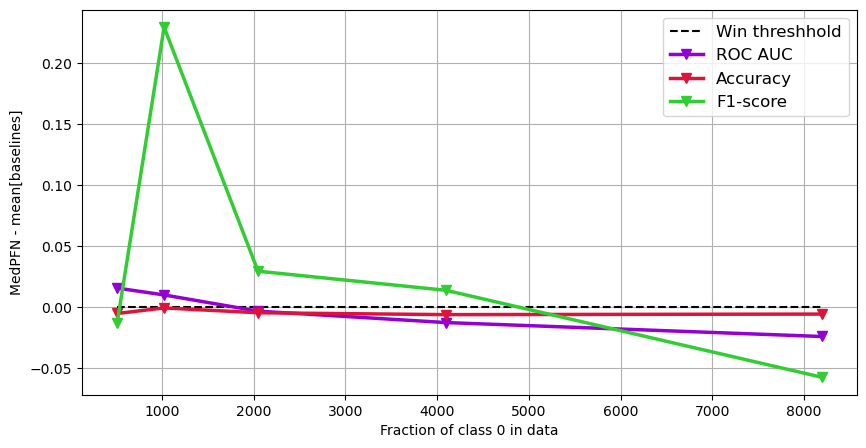

In [141]:

models = ["Majclass", "MedPFN-1", "MedPFN-7", "MedPFN-7FT", "RandomForest", "CatBoost", "XGBoost", "Logistic Regression", "TabPFN", "TabForestPFN"]
fig, axs = plt.subplots(1,1,figsize=(10,5))#plt.subplots(1, 3, figsize=(25, 5))
all_accuracies = []
all_rocs = []
all_f1s = []
lengths = [512,1024,2048,4096,8192]
for m in range(1,len(models)):
    accuracies = []
    rocs = []
    f1s = []
    for cl in lengths:
    
        path = f'results/context_length/context_length_{cl}.csv'
        df = pd.read_csv(path)
        accuracies.append(df.iloc[m,1])
        rocs.append(df.iloc[m,7])
        f1s.append(df.iloc[m,9])
    all_accuracies.append(accuracies)
    all_rocs.append(rocs)
    all_f1s.append(f1s)
    
#axs[0].plot(all_accuracies[3])
#axs[1].plot(all_rocs[3])
#axs[2].plot(all_f1s[2])
mean_accuracies = all_accuracies[3]-np.max(np.array(all_accuracies)[4:],axis=0)
#axs.plot(fracs, mean_accuracies)
mean_rocs = all_rocs[3]-np.max(np.array(all_rocs)[4:],axis=0)
#axs.plot(fracs, mean_rocs)
mean_f1s = all_f1s[3]-np.max(np.array(all_f1s)[4:],axis=0)
#axs.plot(fracs, mean_f1s)
axs.plot(lengths, np.zeros(len(lengths)), linestyle='--', c="black", label="Win threshhold")
axs.plot(lengths, mean_rocs, marker="v", linewidth=2.5, markersize=7.0, label='ROC AUC', c="darkviolet")
axs.plot(lengths, mean_accuracies, marker="v", linewidth=2.5, markersize=7.0, label='Accuracy', c="crimson")
axs.plot(lengths, mean_f1s, marker="v", linewidth=2.5, markersize=7.0, label='F1-score', c="limegreen")
#axs.set_yticks([-0.05,0,0.05,0.1])
#axs.set_xlim(0.5,0.94)
axs.set_xlabel("Fraction of class 0 in data")
axs.set_ylabel("MedPFN - mean[baselines]")
axs.grid()
axs.legend(fontsize=12)
fig.show()


'''df = pd.read_csv(path)
        accuracies.append(df.iloc[m,1])
        rocs.append(df.iloc[m,7])
        f1s.append(df.iloc[m,9])
    axs[0].plot(lengths, accuracies)
    axs[1].plot(lengths, rocs, label = models[m])
    axs[2].plot(lengths, f1s)
    
axs[1].legend(fontsize=12)
fig.show()'''

## Imbalance anaysis

In [121]:
save = True
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 20
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
#run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
#run_name2 = "large_mlp_var_balance_05weight_anova" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ft
#run_name3 = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100_moreweight" ## best start, ft no so good
#run_name = "medium_mlp_var_balance_05weight_anova_200" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
#path2 = dir_path + f"/logs/trainrun_{run_name2}"
#path3 = dir_path + f"/logs/trainrun_{run_name3}"
filename = "model"



models = [
    MajorityClass(),
    #XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=1, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
                    ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    CatBoostGrid(),
    XGBoostGrid(),
    LogisticRegressionClassifier(), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs_forest)
]
reducer  = AnovaSelect()
#for reducer in [AnovaSelect(), RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
#data = clr(all_data)

#all_data = normalize(all_data)

frac = [0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
for f in frac:
    data_c0 = all_data[labels==0]
    data_c1 = all_data[labels==1]
    num_c1 = data_c1.shape[0]
    num_c0 = min(int(num_c1*f/(1-f)),data_c0.shape[0])
    num_c1 = min(num_c1, int(num_c0*(1-f)/f))
    print(num_c1,num_c0)
    data = np.concatenate((data_c0[:num_c0], data_c1[:num_c1]), axis=0)
    print(data.shape)
    labels_new = np.concatenate((np.zeros(num_c0), np.ones(num_c1)))
    data_new, labels_new = unison_shuffled_copies(data, labels_new)
    counts = np.unique(labels_new, return_counts=True)[1]
    print(counts[0]/np.sum(counts))
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
            model, data_new, labels_new, metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)
    
    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    red_name = "imbalance"
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/majclass_{f}.csv'
        results_full.to_csv(save_path)
    print("\n", "\n", red_name, "\n", results_full.round(3))
    #print(results_full.sort_values("roc_auc mean").round(3))

700 7087
(7787, 1391)
0.9101065879029151


C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 imbalance 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.911         0.000           0.000          0.000         0.00       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.907         0.026           0.447          0.277         0.34       0.201         0.869        0.061    0.378   0.219         0.255        0.010
MedPFNClassifier                      0.935         0.011           0.851          0.131         0.36       0.174         0.879        0.054    0.469   0.175         1.609        0.026
MedPFNClassifier                      0.927         0.018           0.660          0.228         0.40       0.179         0.871        0.055    0.478   0.166        10.763        0.108
RandomForestClassifier                0.934         0.011  

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 imbalance 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.920         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.905         0.013           0.386          0.124        0.311       0.109         0.827        0.082    0.341   0.111         0.266        0.022
MedPFNClassifier                      0.924         0.011           0.587          0.224        0.278       0.090         0.851        0.048    0.365   0.105         1.624        0.026
MedPFNClassifier                      0.921         0.014           0.541          0.187        0.333       0.122         0.854        0.048    0.396   0.119        10.702        0.479
RandomForestClassifier                0.932         0.009  

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 imbalance 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.938         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.949         0.012           0.617          0.245        0.371       0.171         0.891        0.054    0.458   0.193         0.342        0.010
MedPFNClassifier                      0.959         0.013           0.900          0.300        0.357       0.172         0.930        0.045    0.501   0.203         1.968        0.038
MedPFNClassifier                      0.955         0.022           0.750          0.316        0.414       0.216         0.928        0.048    0.524   0.241        14.024        0.178
RandomForestClassifier                0.960         0.007  

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 imbalance 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.946         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.959         0.015           0.742          0.303        0.433       0.335         0.897        0.063    0.464   0.273         0.341        0.011
MedPFNClassifier                      0.963         0.019           0.760          0.388        0.400       0.309         0.910        0.059    0.484   0.321         1.957        0.019
MedPFNClassifier                      0.957         0.019           0.678          0.372        0.433       0.309         0.905        0.065    0.474   0.286        13.943        0.122
RandomForestClassifier                0.959         0.012  

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 imbalance 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.955         0.000           0.000          0.000         0.00       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.951         0.008           0.447          0.324         0.20       0.126         0.839        0.094    0.254   0.136         0.338        0.010
MedPFNClassifier                      0.962         0.011           0.713          0.335         0.32       0.133         0.881        0.095    0.418   0.165         1.986        0.051
MedPFNClassifier                      0.956         0.015           0.520          0.288         0.36       0.174         0.876        0.096    0.414   0.210        14.229        0.236
RandomForestClassifier                0.960         0.007  

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 imbalance 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.964         0.000            0.00          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.962         0.004            0.10          0.200        0.050       0.100         0.746        0.199    0.067   0.133         0.344        0.010
MedPFNClassifier                      0.969         0.004            0.50          0.500        0.125       0.125         0.761        0.194    0.200   0.200         1.959        0.031
MedPFNClassifier                      0.969         0.006            0.50          0.447        0.175       0.160         0.758        0.202    0.253   0.225        14.170        0.189
RandomForestClassifier                0.966         0.004  

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 imbalance 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.973         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.972         0.009           0.450          0.400        0.233       0.153         0.890        0.075    0.287   0.202         0.352        0.005
MedPFNClassifier                      0.973         0.006           0.300          0.400        0.133       0.163         0.925        0.080    0.180   0.223         1.984        0.060
MedPFNClassifier                      0.973         0.006           0.300          0.400        0.133       0.163         0.928        0.079    0.180   0.223        14.227        0.242
RandomForestClassifier                0.973         0.000  

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 imbalance 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.982         0.000             0.0            0.0         0.00        0.00         0.500        0.000    0.000     0.0         0.000        0.000
MedPFNClassifier                      0.982         0.000             0.0            0.0         0.00        0.00         0.780        0.131    0.000     0.0         0.345        0.010
MedPFNClassifier                      0.982         0.000             0.0            0.0         0.00        0.00         0.837        0.118    0.000     0.0         1.943        0.036
MedPFNClassifier                      0.982         0.000             0.0            0.0         0.00        0.00         0.840        0.117    0.000     0.0        14.103        0.143
RandomForestClassifier                0.983         0.003  

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 imbalance 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.991         0.000             0.0            0.0          0.0         0.0         0.500        0.000      0.0     0.0         0.000        0.000
MedPFNClassifier                      0.991         0.000             0.0            0.0          0.0         0.0         0.805        0.229      0.0     0.0         0.360        0.006
MedPFNClassifier                      0.991         0.000             0.0            0.0          0.0         0.0         0.814        0.200      0.0     0.0         1.987        0.076
MedPFNClassifier                      0.991         0.000             0.0            0.0          0.0         0.0         0.796        0.233      0.0     0.0        14.202        0.326
RandomForestClassifier                0.991         0.000  

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.9388413889373582


C:\Users\lenna\AppData\Local\Temp\ipykernel_19724\3596895818.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


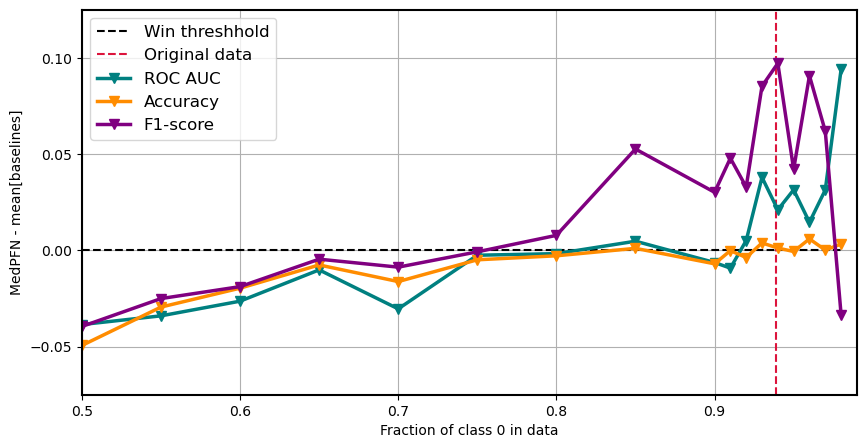

In [128]:
data_imb = all_data[labels==0].shape[0]/(all_data[labels==0].shape[0]+all_data[labels==1].shape[0])
print(data_imb)
models = ["Majclass", "MedPFN-1", "MedPFN-7", "MedPFN-7FT", "RandomForest", "CatBoost", "XGBoost", "Logistic Regression", "TabPFN", "TabForestPFN"]
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
all_accuracies = []
all_rocs = []
all_f1s = []
fracs = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98]
for m in range(0,len(models)):
    accuracies = []
    rocs = []
    f1s = []
    for f in fracs:
    
        path = f'results/imbalance/majclass_{f}.csv'
        df = pd.read_csv(path)
        accuracies.append(df.iloc[m,1])
        rocs.append(df.iloc[m,7])
        f1s.append(df.iloc[m,9])
    all_accuracies.append(accuracies)
    all_rocs.append(rocs)
    all_f1s.append(f1s)
    
#axs[0].plot(all_accuracies[3])
#axs[1].plot(all_rocs[3])
#axs[2].plot(all_f1s[2])
mean_accuracies = all_accuracies[3]-np.mean(np.array(all_accuracies)[4:],axis=0)
#axs.plot(fracs, mean_accuracies)
mean_rocs = all_rocs[3]-np.mean(np.array(all_rocs)[4:],axis=0)
#axs.plot(fracs, mean_rocs)
mean_f1s = all_f1s[3]-np.mean(np.array(all_f1s)[4:],axis=0)
#axs.plot(fracs, mean_f1s)
axs.plot(fracs, np.zeros(len(fracs)), linestyle='--', c="black", label="Win threshhold")
axs.vlines(data_imb,-0.075,0.125, linestyles="dashed", colors="crimson", label="Original data")
axs.plot(fracs, mean_rocs, marker="v", linewidth=2.5, markersize=7.0, label='ROC AUC', c="teal")
axs.plot(fracs, mean_accuracies, marker="v", linewidth=2.5, markersize=7.0, label='Accuracy', c="darkorange")
axs.plot(fracs, mean_f1s, marker="v", linewidth=2.5, markersize=7.0, label='F1-score', c="purple")
axs.set_yticks([-0.05,0,0.05,0.1])
axs.set_ylim(-0.075,0.125)
axs.set_xlim(0.5,0.99)
axs.set_xlabel("Fraction of class 0 in data")
axs.set_ylabel("MedPFN - mean[baselines]")
axs.grid()
axs.legend(fontsize=12)
fig.show()
fig.savefig("results/plots/imbalance.eps")

## Ensemble testing

In [14]:
save = True
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 7
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"

ens_num = 20

    
reducer  = AnovaSelect()

results_mean = pd.DataFrame(np.zeros((ens_num, len(metrics)+1)),
                            index=np.arange(1,1+ens_num),
                            columns=metrics+["runtime"])
results_std = pd.DataFrame(np.zeros((ens_num, len(metrics)+1)), 
                           index=np.arange(1,1+ens_num),
                           columns=metrics+["runtime"])

for ens in range(1,ens_num+1):
    model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process)
    results_mean.iloc[ens-1,:], results_std.iloc[ens-1,:] = cross_validate_sample(
        model, all_data, labels, metrics, strat_split, cv, sampling, 
        reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
        recomp=recomp)
    #print(results_mean)
results_mean = results_mean.add_suffix(" mean")
results_std = results_std.add_suffix(" std")
results_full = pd.concat((results_mean, results_std), axis=1)
cols = results_full.columns.tolist()
new_cols = []
for i in range(int(len(cols)/2)):
    new_cols.append(cols[i])
    new_cols.append(cols[i+int(len(cols)/2)])
results_full = results_full[new_cols]
red_name = "ensemble"
if save:
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = f'results/{red_name}/medpfn_maxens{ens_num}'
    results_full.to_csv(save_path)
print("\n", "\n", red_name, "\n", results_full.round(3))
    #print(results_full.sort_values("roc_auc mean").round(3))

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 ensemble 
     accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
1           0.947         0.006           0.400          0.436        0.117       0.130         0.870        0.071    0.166   0.170         0.460        0.080
2           0.947         0.006           0.300          0.306        0.167       0.167         0.911        0.063    0.213   0.214         1.368        0.113
3           0.951         0.009           0.600          0.436        0.183       0.138         0.907        0.060    0.266   0.189         1.978        0.240
4           0.950         0.008           0.533          0.393        0.200       0.145         0.922        0.054    0.276   0.191         2.562        0.185
5           0.950         0.008           0.533          0.393        0.200       0.145         0.919        0.055    0.276   0.191         2.810        0.218
6           0.950         0.008

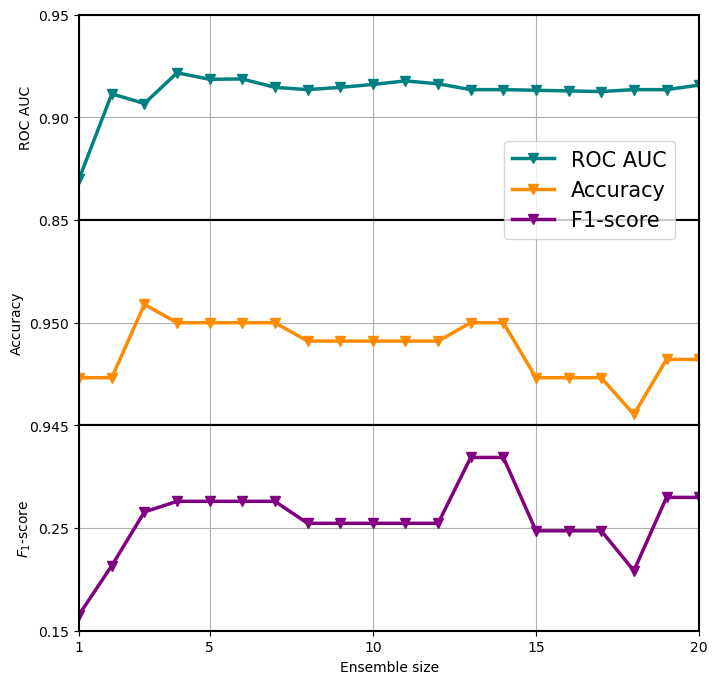

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [131]:
ens_num = 20
results_full = pd.read_csv(f'results/ensemble/medpfn_maxens{20}')
#for i in range(ens_num):
x = np.arange(1,1+ens_num)
acc = results_full.iloc[:,1]
acc_error = results_full.iloc[:,2]
roc = results_full.iloc[:,7]
roc_error = results_full.iloc[:,8]
f1 = results_full.iloc[:,9]
f1_error = results_full.iloc[:,10]

heights = [1,1,1]
mpl.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(3, 1, figsize=(8, 8), gridspec_kw={'height_ratios': heights},sharex=True)

colors = ["teal", "darkorange", "purple"]
#ax[0].fill_between(x, roc - roc_error, roc + roc_error, alpha=0.25, color=colors[0])
#ax[1].fill_between(x, acc - acc_error, acc + acc_error, alpha=0.25,color=colors[1])
#ax[2].fill_between(x, f1 - f1_error, f1 + f1_error, alpha=0.25, color=colors[2])
ax[1].plot(x, acc, marker="v", linewidth=2.5, markersize=7.0, label='Accuracy', c=colors[1])
ax[0].plot(x, roc, marker="v", linewidth=2.5, markersize=7.0, label='ROC AUC', c=colors[0])
ax[2].plot(x, f1, marker="v", linewidth=2.5, markersize=7.0, label='F1-score', color=colors[2])

ax[0].set_ylim(0.85,0.95)
ax[1].set_ylim(0.945,0.955)
ax[2].set_ylim(0.15,0.35)
ax[0].set_yticks([0.85,0.9,0.95])
ax[1].set_yticks([0.945,0.95])
ax[2].set_yticks([0.15,0.25])
# Adding labels and title
ax[0].set_ylabel('ROC AUC')
ax[1].set_ylabel('Accuracy')
ax[2].set_ylabel('$F_1$-score')
ax[2].set_xlabel('Ensemble size')
ax[2].set_xticks([1,5,10,15,20])
#plt.yticks([0.3,0.6,0.9])
ax[2].set_xlim(1,20)
#plt.ylim(0,1)
ax[0].grid()
ax[1].grid()
ax[2].grid()
#plt.ylabel('Metric score')
#plt.title('Plot with Uncertainty Band')
fig.legend(loc=(0.7,0.65), fontsize=15)
plt.subplots_adjust(hspace=0)
#plt.tight_layout()
plt.show()
fig.savefig("results/plots/ensemble.eps")

## Finetuning analysis ##

In [8]:
save = True
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ftpath = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
path = dir_path + f"/logs/trainrun_{run_name}"
ens_num = 10

    
reducer  = AnovaSelect()

results_mean = pd.DataFrame(np.zeros((ens_num, len(metrics)+1)),
                            index=np.arange(1,1+ens_num),
                            columns=metrics+["runtime"])
results_std = pd.DataFrame(np.zeros((ens_num, len(metrics)+1)), 
                           index=np.arange(1,1+ens_num),
                           columns=metrics+["runtime"])

lrs = np.arange(0,50,5)
size = min(labels.shape[0],np.floor(max_samples*(cv/(cv-1))))
runs = int(all_data.shape[0]//size)
data_sections, label_sections = stratified_split(all_data, labels,cv=runs)


for ens in range(len(lrs)):
    print(ens)
    for section in range(runs):
    #print(section)
        model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
                ft_epochs=lrs[ens], ft_lr=ft_lr)
        out_mean, out_std = cross_validate_sample(
            model, data_sections[section], label_sections[section], metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)
        results_mean.iloc[ens,:] += out_mean
        results_std.iloc[ens,:] += out_std
results_mean=results_mean/runs
results_std=results_std/runs
    
results_mean = results_mean.add_suffix(" mean")
results_std = results_std.add_suffix(" std")
results_full = pd.concat((results_mean, results_std), axis=1)
cols = results_full.columns.tolist()
new_cols = []
for i in range(int(len(cols)/2)):
    new_cols.append(cols[i])
    new_cols.append(cols[i+int(len(cols)/2)])
results_full = results_full[new_cols]
red_name = "finetuning"
if save:
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = f'results/{red_name}/new_medpfn_maxsteps{ens_num}_lr{ft_lr}'
    results_full.to_csv(save_path)
print("\n", "\n", red_name, "\n", results_full.round(3))
    #print(results_full.sort_values("roc_auc mean").round(3))

0


KeyboardInterrupt: 

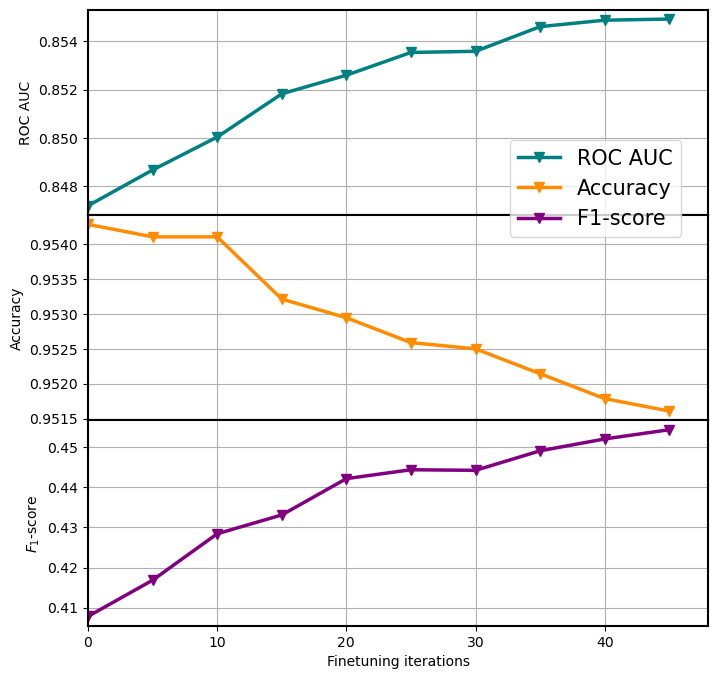

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
ens_num = 50
results_full = pd.read_csv(f'results/finetuning/new_medpfn_maxsteps{10}_lr{1e-05}')
#for i in range(ens_num):
x = np.arange(0,ens_num, 5)
acc = results_full.iloc[:,1]
acc_error = results_full.iloc[:,2]
roc = results_full.iloc[:,7]
roc_error = results_full.iloc[:,8]
f1 = results_full.iloc[:,9]
f1_error = results_full.iloc[:,10]

heights = [1,1,1]
mpl.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(3, 1, figsize=(8, 8), gridspec_kw={'height_ratios': heights},sharex=True)

colors = ["teal", "darkorange", "purple"]
#ax[0].fill_between(x, roc - roc_error, roc + roc_error, alpha=0.25, color=colors[0])
#ax[1].fill_between(x, acc - acc_error, acc + acc_error, alpha=0.25,color=colors[1])
#ax[2].fill_between(x, f1 - f1_error, f1 + f1_error, alpha=0.25, color=colors[2])
ax[1].plot(x, acc, marker="v", linewidth=2.5, markersize=7.0, label='Accuracy', c=colors[1])
ax[0].plot(x, roc, marker="v", linewidth=2.5, markersize=7.0, label='ROC AUC', c=colors[0])
ax[2].plot(x, f1, marker="v", linewidth=2.5, markersize=7.0, label='F1-score', color=colors[2])

#ax[0].set_ylim(0.9,0.94)
#ax[1].set_ylim(0.90,0.98)
#ax[2].set_ylim(0.2,0.6)
#ax[0].set_yticks([0.9,0.92,0.94])
#ax[1].set_yticks([0.90,0.94])
#ax[2].set_yticks([0.2,0.4])
# Adding labels and title
ax[2].set_xlabel('Finetuning iterations')
ax[0].set_ylabel('ROC AUC')
ax[1].set_ylabel('Accuracy')
ax[2].set_ylabel('$F_1$-score')
#ax[2].set_xticks(np.arange(0,50,10))
#plt.yticks([0.3,0.6,0.9])
ax[2].set_xlim(0,48)
#plt.ylim(0,1)
ax[0].grid()
ax[1].grid()
ax[2].grid()
#plt.ylabel('Metric score')
#plt.title('Plot with Uncertainty Band')
fig.legend(loc=(0.7,0.65), fontsize=15)
plt.subplots_adjust(hspace=0)
#plt.tight_layout()
plt.show()
fig.savefig("results/plots/finetuning.eps")

### Feature removal ###

In [32]:
save = True
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 20
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"


models = [
    MajorityClass(),
    #XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=1, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
                    ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    #CatBoostGrid(),
    #XGBoostGrid(),
    LogisticRegressionClassifier(), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs_forest)
]
reducer  = AnovaSelect()
#for reducer in [AnovaSelect(), RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
#data = clr(all_data)

#all_data = normalize(all_data)
to_delete = [0,1,5,10,25,50,100,250,500]
for best_delete in to_delete:
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
            model, all_data, labels, metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)
    
    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    red_name = "feature_removal"
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/best_delete{best_delete}.csv'
        results_full.to_csv(save_path)
    print("\n", "\n", best_delete, "\n", results_full.round(3))
    #print(results_full.sort_values("roc_auc mean").round(3))

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 0 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.946         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.947         0.006           0.400          0.436        0.117       0.130         0.870        0.071    0.166   0.170         0.722        0.299
MedPFNClassifier                      0.950         0.008           0.533          0.393        0.200       0.145         0.919        0.055    0.276   0.191         2.673        0.387
MedPFNClassifier                      0.949         0.010           0.552          0.117        0.417       0.171         0.917        0.061    0.456   0.105        21.327        2.060
RandomForestClassifier                0.950         0.013          

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 1 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.946         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.941         0.004           0.167          0.211        0.067       0.082         0.822        0.069    0.094   0.116         0.297        0.011
MedPFNClassifier                      0.949         0.011           0.513          0.397        0.217       0.150         0.890        0.046    0.290   0.200         1.926        0.170
MedPFNClassifier                      0.949         0.011           0.600          0.169        0.433       0.153         0.892        0.051    0.466   0.097        13.004        0.472
RandomForestClassifier                0.943         0.006          

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 5 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.946         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.945         0.004           0.000          0.000        0.000       0.000         0.787        0.056    0.000   0.000         0.417        0.043
MedPFNClassifier                      0.946         0.011           0.483          0.410        0.150       0.117         0.848        0.051    0.215   0.161         2.217        0.073
MedPFNClassifier                      0.953         0.011           0.611          0.191        0.417       0.154         0.839        0.054    0.477   0.127        17.612        1.621
RandomForestClassifier                0.938         0.010          

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 10 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.946         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.946         0.003           0.000          0.000        0.000       0.000         0.781        0.066    0.000   0.000         0.285        0.035
MedPFNClassifier                      0.941         0.017           0.383          0.409        0.117       0.130         0.839        0.061    0.171   0.181         1.698        0.127
MedPFNClassifier                      0.951         0.011           0.503          0.194        0.433       0.238         0.837        0.066    0.450   0.195        12.035        0.735
RandomForestClassifier                0.941         0.006         

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 25 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.946         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.944         0.008           0.100          0.300        0.017       0.050         0.801        0.101    0.029   0.086         0.257        0.010
MedPFNClassifier                      0.941         0.009           0.300          0.384        0.083       0.083         0.854        0.073    0.122   0.125         1.584        0.019
MedPFNClassifier                      0.941         0.020           0.536          0.268        0.350       0.117         0.835        0.095    0.396   0.116        10.326        0.102
RandomForestClassifier                0.947         0.006         

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 50 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.946         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.942         0.004           0.183          0.229        0.067       0.082         0.790        0.165    0.097   0.119         0.247        0.009
MedPFNClassifier                      0.942         0.004           0.217          0.224        0.083       0.083         0.828        0.111    0.119   0.120         1.579        0.030
MedPFNClassifier                      0.942         0.007           0.218          0.236        0.117       0.150         0.817        0.125    0.147   0.172        10.249        0.055
RandomForestClassifier                0.947         0.005         

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 100 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.946         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.935         0.006           0.117          0.183        0.050       0.076         0.755        0.138    0.069   0.106         0.247        0.012
MedPFNClassifier                      0.945         0.007           0.350          0.391        0.083       0.083         0.815        0.116    0.132   0.133         1.551        0.016
MedPFNClassifier                      0.941         0.009           0.250          0.403        0.050       0.076         0.819        0.113    0.082   0.126        10.229        0.049
RandomForestClassifier                0.946         0.003        

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 250 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.946         0.000           0.000          0.000        0.000       0.000         0.500        0.000    0.000   0.000         0.000        0.000
MedPFNClassifier                      0.946         0.000           0.000          0.000        0.000       0.000         0.470        0.080    0.000   0.000         0.254        0.003
MedPFNClassifier                      0.946         0.000           0.000          0.000        0.000       0.000         0.751        0.070    0.000   0.000         1.550        0.020
MedPFNClassifier                      0.946         0.000           0.000          0.000        0.000       0.000         0.768        0.071    0.000   0.000        10.245        0.089
RandomForestClassifier                0.946         0.000        

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 500 
                               accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                         0.946         0.000             0.0            0.0          0.0         0.0         0.500        0.000      0.0     0.0         0.000        0.000
MedPFNClassifier                      0.946         0.000             0.0            0.0          0.0         0.0         0.604        0.126      0.0     0.0         0.252        0.012
MedPFNClassifier                      0.946         0.000             0.0            0.0          0.0         0.0         0.552        0.128      0.0     0.0         1.589        0.039
MedPFNClassifier                      0.946         0.000             0.0            0.0          0.0         0.0         0.641        0.122      0.0     0.0        10.281        0.075
RandomForestClassifier                0.946         0.000        

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## New data

In [26]:
path = "datasets/external_pdac.csv"
df = pd.read_csv(path)
df_data = df.iloc[:,2:-5]
data = df_data.to_numpy()
labels = df["Disease"].to_numpy()
labels[labels=="Healthy"] = 0
labels[labels=="PDAC"] = 1
all_data = data
data_c0 = data[labels==0]
data_c1 = data[labels==1]
num_c1 = data_c1.shape[0]
num_c0 = int(num_c1*0.05)
data = np.concatenate((data_c0[:num_c0], data_c1), axis=0)
#labels = np.concatenate((np.zeros(num_c0), np.ones(num_c1)))
all_data, labels = unison_shuffled_copies(data, labels)
all_data = data_to_comp(all_data)

In [28]:
save = False
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 20
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
#run_name2 = "large_mlp_var_balance_05weight_anova" ## das aller bestigste
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## das aller bestigste
run_name2 = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## das aller bestigste ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_200" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
path2 = dir_path + f"/logs/trainrun_{run_name2}"
filename = "model"


models = [
    #CatBoostOptim(n_optim=cat_optim),
    MajorityClass(),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process, ft_epochs=ft_epochs, ft_lr=ft_lr),
    MedPFNClassifier(base_path=path2, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path2, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process, ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    #CatBoostGrid(),
    #XGBoostGrid(),
    #XGBoostOptim(n_optim=n_optim),
    LogisticRegression(max_iter=1000), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
]

for reducer in [AnovaSelect(), RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
            model, all_data, labels, metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)

    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    red_name = reducer.__class__.__name__
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/baseline_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}'
        results_full.to_csv(save_path)
    print("\n", "\n", red_name, "\n", results_full.round(3))
    #print(results_full.sort_values("roc_auc mean").round(3))

2024-11-05 15:24:41.403 | INFO     | tabularbench.core.trainer_finetune:train:83 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.2916 | Val score: 0.8485
2024-11-05 15:24:42.088 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 001 | Train loss: 0.5151 | Train score: 0.7308 | Val loss: 0.3171 | Val score: 0.7879
2024-11-05 15:24:42.976 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 002 | Train loss: 0.4749 | Train score: 0.7692 | Val loss: 0.3599 | Val score: 0.8788
2024-11-05 15:24:43.628 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 003 | Train loss: 0.4746 | Train score: 0.7308 | Val loss: 0.3794 | Val score: 0.8788
2024-11-05 15:24:44.213 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 004 | Train loss: 0.4510 | Train score: 0.7308 | Val loss: 0.3534 | Val score: 0.8182
2024-11-05 15:24:44.953 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 005 | Train loss: 0.3663 | Train sco


 
 AnovaSelect 
                         accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                   0.778         0.000           0.778          0.000        1.000       0.000         0.500        0.000    0.875   0.000         0.000        0.000
XGBClassifier                   0.733         0.085           0.819          0.048        0.843       0.083         0.657        0.083    0.830   0.060         0.006        0.000
MedPFNClassifier                0.744         0.062           0.783          0.027        0.929       0.071         0.602        0.159    0.849   0.041         0.505        0.053
MedPFNClassifier                0.750         0.062           0.789          0.037        0.929       0.055         0.609        0.145    0.852   0.038         3.888        0.581
MedPFNClassifier                0.711         0.078           0.786          0.046     

2024-11-05 15:28:06.093 | INFO     | tabularbench.core.trainer_finetune:train:83 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.5224 | Val score: 0.7879
2024-11-05 15:28:06.614 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 001 | Train loss: 0.5411 | Train score: 0.7692 | Val loss: 0.5159 | Val score: 0.7879
2024-11-05 15:28:07.055 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 002 | Train loss: 0.5849 | Train score: 0.7692 | Val loss: 0.5170 | Val score: 0.7879
2024-11-05 15:28:07.526 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 003 | Train loss: 0.5409 | Train score: 0.7692 | Val loss: 0.5170 | Val score: 0.7879
2024-11-05 15:28:07.992 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 004 | Train loss: 0.5388 | Train score: 0.7692 | Val loss: 0.5171 | Val score: 0.7879
2024-11-05 15:28:08.524 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 005 | Train loss: 0.5403 | Train sco


 
 RandomSelect 
                         accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                   0.778         0.000           0.778          0.000        1.000       0.000         0.500        0.000    0.875   0.000         0.000        0.000
XGBClassifier                   0.656         0.085           0.762          0.038        0.807       0.091         0.569        0.108    0.783   0.061         0.008        0.003
MedPFNClassifier                0.628         0.079           0.767          0.057        0.757       0.116         0.462        0.112    0.756   0.062         0.460        0.018
MedPFNClassifier                0.722         0.086           0.781          0.042        0.893       0.080         0.521        0.159    0.832   0.055         3.041        0.227
MedPFNClassifier                0.694         0.090           0.792          0.046    

2024-11-05 15:31:30.632 | INFO     | tabularbench.core.trainer_finetune:train:83 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.5780 | Val score: 0.7576
2024-11-05 15:31:31.170 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 001 | Train loss: 0.4803 | Train score: 0.7308 | Val loss: 0.5725 | Val score: 0.7576
2024-11-05 15:31:31.687 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 002 | Train loss: 0.4833 | Train score: 0.8077 | Val loss: 0.5627 | Val score: 0.7576
2024-11-05 15:31:32.346 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 003 | Train loss: 0.4398 | Train score: 0.8077 | Val loss: 0.5768 | Val score: 0.7576
2024-11-05 15:31:32.959 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 004 | Train loss: 0.4663 | Train score: 0.7692 | Val loss: 0.6151 | Val score: 0.7273
2024-11-05 15:31:33.504 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 005 | Train loss: 0.4590 | Train sco


 
 NonZeroSelect 
                         accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
MajorityClass                   0.778         0.000           0.778          0.000        1.000       0.000         0.500        0.000    0.875   0.000         0.000        0.000
XGBClassifier                   0.756         0.051           0.820          0.060        0.893       0.092         0.579        0.183    0.849   0.036         0.013        0.001
MedPFNClassifier                0.783         0.084           0.828          0.057        0.914       0.089         0.620        0.181    0.867   0.056         0.463        0.018
MedPFNClassifier                0.789         0.078           0.822          0.059        0.936       0.067         0.620        0.201    0.873   0.048         4.709        2.812
MedPFNClassifier                0.728         0.080           0.804          0.041   


KeyboardInterrupt



In [ ]:
save = False
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 20
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
#run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
#run_name2 = "large_mlp_var_balance_05weight_anova" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ft
#run_name3 = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100_moreweight" ## best start, ft no so good
#run_name = "medium_mlp_var_balance_05weight_anova_200" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
#path2 = dir_path + f"/logs/trainrun_{run_name2}"
#path3 = dir_path + f"/logs/trainrun_{run_name3}"
filename = "model"


models = [
    MajorityClass(),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=1, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
                    ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    #CatBoostGrid(),
    #XGBoostGrid(),
    LogisticRegressionClassifier(), 
    #TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs_forest)
]
reducer  = AnovaSelect()
#for reducer in [AnovaSelect(), RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
#data = clr(all_data)

#all_data = normalize(all_data)

results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                            index=[m.__class__.__name__ for m in models],
                            columns=metrics+["runtime"])
results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                           index=[m.__class__.__name__ for m in models],
                           columns=metrics+["runtime"])

for ii, model in enumerate(models):
    results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
        model, all_data, labels, metrics, strat_split, cv, sampling, 
        reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
        recomp=recomp)

results_mean = results_mean.add_suffix(" mean")
results_std = results_std.add_suffix(" std")
results_full = pd.concat((results_mean, results_std), axis=1)
cols = results_full.columns.tolist()
new_cols = []
for i in range(int(len(cols)/2)):
    new_cols.append(cols[i])
    new_cols.append(cols[i+int(len(cols)/2)])
results_full = results_full[new_cols]
red_name = reducer.__class__.__name__
if save:
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = f'results/{red_name}/baseline_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}.csv'
    results_full.to_csv(save_path)
print("\n", "\n", red_name, "\n", results_full.round(3))
#print(results_full.sort_values("roc_auc mean").round(3))

In [ ]:
save = True
sampling = None
cv = 7
best_delete = 0
strat_split = True
n_optim = 1000
cat_optim = 10
ft_epochs = 10
ft_lr = 1e-7
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 7
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
run_name = "medium_mlp_var_balance_05weight_anova" ### BEST!!!!!! ####
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
models = [
    #CatBoostOptim(n_optim=cat_optim),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    RandomForestClassifier(),
    #XGBoostOptim(n_optim=n_optim),
    LogisticRegression(max_iter=1000), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
]

#for reducer in [AnovaSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
reducer = AnovaSelect()
#for reduce_data in [top_anova, top_non_zero, top_mean, top_std, top_max, pca_reduce]:
    #data = reduce_data(all_data, labels, 100)
    #print(all_data.shape)
for best_delete in range(0,510,10):
    #reducer.k = 100
    #reducer = None
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
            model, all_data, labels, metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete)

    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    red_name = "feature_select_shift_10step"
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/{best_delete}_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}'
        results_full.to_csv(save_path)
    print("\n", "\n", red_name, "\n", results_full.round(3))

In [ ]:
all_data = []
all_labels = []
for p in ["datasets/CRC_AUS_LOSO.csv", 
          "datasets/CRC_FRA_LOSO.csv",
         "datasets/CRC_CHI_LOSO.csv",
         "datasets/CRC_GER_LOSO.csv",
         #"datasets/CRC_IND_additional.csv",
         "datasets/CRC_USA_LOSO.csv"]:
    df = pd.read_csv(p)
    df_binary = df.loc[(df["disease"] == "healthy") | (df["disease"]=="CRC")]
    df_data = df_binary.iloc[:,4:]
    data = df_data.to_numpy()
    labels = df_binary["disease"].to_numpy()
    labels[labels=="healthy"] = 0
    labels[labels=="CRC"] = 1
    data = (1/np.sum(data, axis=1, keepdims=True))*data
    all_data.append(data)
    all_labels.append(labels)

all_data = np.concatenate(all_data,axis=0)
labels = np.concatenate(all_labels)
all_data, labels = unison_shuffled_copies(all_data, labels, seed=412)
c1_ind = (labels==1).nonzero()[0]
c1_del = c1_ind[:int(len(c1_ind)*0.97)]
all_data, labels = np.delete(all_data, c1_del, axis=0), np.delete(labels, c1_del, axis=0)

In [ ]:
ws = 20
rocs = []
f1s = []
for i in range(0,510,10):
    results = pd.read_csv(f'results/feature_select_shift_10step/{i}_cv{7}_mxsamp{1024}_sd{42}_ovrw{1}')
    rocs.append(results["roc_auc mean"].values)
    f1s.append(results["f1 mean"].values)
rocs = np.array(rocs)
f1s = np.array(f1s)
labels = results.iloc[:,0].values
plt.figure(figsize=(12,3), dpi=200)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
colors = []
for cl in range(rocs.shape[1]):
    ax1.plot(np.arange(rocs.shape[0]-ws+1)*10, moving_average(rocs[:,cl], ws), label=labels[cl])
    ax2.plot(np.arange(rocs.shape[0]-ws+1)*10, moving_average(f1s[:,cl], ws), label=labels[cl])
plt.suptitle("ROC AUC and F1-Score shifting feature selection")
#ax1.set_title("ROC AUC")
ax1.set_ylabel("ROC AUC")
#ax2.set_title("F1-Score")
ax2.set_xlabel("feature shift")
ax2.set_ylabel("F1")
ax1.legend(fontsize=7)
plt.show()

In [ ]:
counts = np.count_nonzero(all_data, axis=0)
counts = 1-counts/all_data.shape[0]
means = np.mean(all_data, axis=0)
plt.scatter(counts, means, s=1)
plt.show()
plt.scatter(counts, np.max(all_data, axis=0), s=1)

In [ ]:
print(error)

In [ ]:
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline"
run_name = "medium_net_mlp_balance_bsplit_baseline_longer"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
for sampling in [None]:#, undersample]:
    cv = 5
    strat_split = True
    n_optim = 1000
    cat_optim = 10
    ft_epochs = 10
    ft_lr = 1e-8
    max_s = 1024
    max_q = 128
    max_samples = None
    no_pre_process = False
    multi_decoder = None
    N_ens = 5
    metrics = ["accuracy", "precision", "recall", "roc_auc"]
    models = [
        #CatBoostOptim(n_optim=cat_optim),
        #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder, ft_epochs=ft_epochs, ft_lr=ft_lr,
        #                 max_s=max_s, max_q=max_q, no_preprocess_mode=no_pre_process),
        MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
        #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=5, no_preprocess_mode=True),
        XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
        XGBoostOptim(n_optim=n_optim),
        LogisticRegression(max_iter=500), 
        TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
        TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
    ]
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(model, data, labels, metrics, strat_split, cv, sampling, max_samples)
    #results_sorted = results.sort_values("roc_auc")
    #print(results_sorted)
    print(results_mean)
    print(results_std)

In [ ]:
cols = []
for m in metrics + "runtime":
    cols.append(m)
    cols.append(m+" std")

In [ ]:

dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
#model, config = load_model(path, filename, device="cpu", eval_positions=None, verbose=0)
#pred_model = TabPFNClassifier(model[2], config, device="cpu", N_ensemble_configurations=5, no_preprocess_mode=False)
for sampling in [None]:
    cv = 3
    strat_split = True
    n_optim = 10
    ft_epochs = 10
    max_samples = None
    metrics = metrics = ["accuracy", "precision", "recall", "roc_auc"]
    models = [
        RandomForestClassifier()
        #CatBoostOptim(n_optim=n_optim),
        #pred_model,
        #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=3, no_preprocess_mode=True),
        #XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
        #XGBoostOptim(n_optim=n_optim),
        #LogisticRegression(max_iter=500), 
        #TabPFNClassifier(device='cpu', N_ensemble_configurations=3, no_preprocess_mode=True),
        #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
    ]
    results = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                           index=[m.__class__.__name__ for m in models],
                          columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results.iloc[ii,:] = cross_validate_sample(model, data, labels, metrics, strat_split, cv, sampling, max_samples)
    results_sorted = results.sort_values("roc_auc")
    
    print(results_sorted)

In [ ]:
print(results_sorted)